In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lenskit import crossfold as xf

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
class Data:
    def __init__(self):
        self.load_data()
        
    def load_data(self):
        self.ratings = pd.read_csv('./data/ratings.csv', sep='\t', encoding='latin-1', 
                                   usecols=['user_id', 'movie_id', 'rating'])
        self.users = pd.read_csv('./data/users.csv', sep='\t', encoding='latin-1', 
                                 usecols=['user_id', 'gender', 'zipcode'])
        self.users['user'] = self.users.index
        self.movies = pd.read_csv('./data/movies.csv', sep='\t', encoding='latin-1', 
                                  usecols=['movie_id', 'title', 'genres'])
        self.movies['item'] = self.movies.index

In [4]:
data = Data()
ratings_new = data.movies.merge(data.ratings, on='movie_id').drop('genres', axis=1)
ratings_user_item_idx = ratings_new.merge(data.users, on='user_id').drop(['gender', 'zipcode'], axis=1)
print(ratings_user_item_idx.head())

   movie_id                                      title  item  user_id  rating  \
0         1                           Toy Story (1995)     0        1       5   
1        48                          Pocahontas (1995)    47        1       5   
2       150                           Apollo 13 (1995)   148        1       5   
3       260  Star Wars: Episode IV - A New Hope (1977)   257        1       4   
4       527                    Schindler's List (1993)   523        1       5   

   user  
0     0  
1     0  
2     0  
3     0  
4     0  


In [7]:
max_rating = 5 # for one hot encoding
num_users = len(data.users)
num_movies = len(data.movies)
num_ratings = len(data.ratings)
complete_num_ratings = num_movies * num_users
print(max_rating, num_users, num_movies, num_ratings, complete_num_ratings)

5 6040 3883 1000209 23453320


In [8]:
# This function transforms the ratings to the required input format of RBM
max_rating = 5
def get_rating_for_rbm(ratings):
    ratings_grouped_user = ratings.groupby('user')
    user_item_rating = np.zeros([num_users, num_movies, max_rating])
    for user, group in ratings_grouped_user:
        for movie in group.iterrows():
            movie = movie[1]
            movie_id = movie['item']
            user_id = movie['user']
            rating = movie['rating'] - 1
            user_item_rating[user_id][movie_id][rating] = 1 
    # Reshape matrix of dimension (n_users, n_movies, 5) to be (n_users, n_movies * 5)
    reshape_rating = np.reshape(user_item_rating, [user_item_rating.shape[0],-1]).astype(dtype=np.float32)
    return reshape_rating

In [9]:
rating_rbm = get_rating_for_rbm(ratings_user_item_idx)

In [10]:
print(rating_rbm.shape)

(6040, 19415)


In [11]:
np.random.shuffle(rating_rbm)
test_rating_rbm = rating_rbm[6000:,]
train_rating_rbm = rating_rbm[:6000,]

In [12]:
print(test_rating_rbm.shape)
print(train_rating_rbm.shape)

(40, 19415)
(6000, 19415)


In [21]:
import math
class RBM:
    def __init__(self,  input_data, test_data, n_hidden = 100, lr = 0.1, batch_size = 100, gaussian = False):
        self.n_hidden = n_hidden
        self.n_visible = input_data.shape[1] # input_data has shape (users, (movies * max_ratings))
        self.input_data = input_data
        self.test_data = test_data
        self.batch_size = batch_size
        self.gaussian = gaussian
        # Set model parameters for RBM
        self.v_bias = tf.Variable(tf.zeros([self.n_visible]), name='v_bias')  # Bias for visible units
        self.h_bias = tf.Variable(tf.zeros([self.n_hidden]), name='h_bias')  # Bias for hidden units
        self.W = tf.Variable(tf.truncated_normal([self.n_visible, self.n_hidden], stddev=0.01), name='W')
        self.create_graph(lr)
    
    def gibbs_step(self, steps):
        v0 = self.v0
        for i in range(steps):
            # Phase 1: Input Processing / positive phase
            _h0 = tf.nn.sigmoid(tf.matmul(v0, self.W) + self.h_bias)  # Visible layer activation (p(h | v))
            self.h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))  # Gibb's Sampling (get h )

            # Phase 2: Reconstruction / negative phase
            _v1 = tf.nn.sigmoid(tf.matmul(self.h0, tf.transpose(self.W)) + self.v_bias)  # Hidden layer activation p(v | h)
            self.v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
            self.h1 = tf.nn.sigmoid(tf.matmul(self.v1, self.W) + self.h_bias)
            
            v0 = self.v1

        
    def gibbs_step_with_gaussian(self, steps):
        v0 = self.v0
        for i in range(steps):
            # Phase 1: Input Processing
            self._h0_prob = tf.nn.sigmoid(-(1.-self.h_bias-tf.matmul(v0, self.W) ** 2) / 2.)
            self.h0 = self._h0_prob / math.sqrt(2.* math.pi)
            
            # Phase 2: Reconstruction
            _v1 = tf.nn.sigmoid(tf.matmul(self.h0, tf.transpose(self.W)) + self.v_bias)  # Hidden layer activation p(v | h)
            self.v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
            self._h1_prob = tf.nn.sigmoid(-(1.-self.h_bias-tf.matmul(self.v1, self.W)**2)/2.)
            self.h1 = self._h1_prob / math.sqrt(2. * math.pi)
            
            v0 = self.v1
    
    def create_graph(self, lr = 0.05):
        # create mask for ratings not provided
        self.v0 = tf.placeholder(tf.float32, [None, self.n_visible])
        self.mask = self.v0
        self.mask = tf.reshape(self.mask,[self.batch_size, -1, max_rating])
        self.mask = tf.reduce_sum(self.mask,axis = 2)
        self.mask = tf.expand_dims(self.mask,axis = 2)
        self.mask = tf.tile(self.mask, [1,1,5])
        self.mask = tf.reshape(self.mask,[self.batch_size,-1])
        if self.gaussian:
            self.gibbs_step_with_gaussian(1)
        else:
            self.gibbs_step(3)
        
        # Learning rate
        self.alpha = lr

        # Create the gradients for the positive and negative step
        self.w_pos_grad = tf.matmul(tf.transpose(self.v0 * self.mask), self.h0)
        self.w_neg_grad = tf.matmul(tf.transpose(self.v1 * self.mask), self.h1) 

        # Calculate the Contrastive Divergence using the gradients. Maximize CD
        # The denominator is to average over all N users
        self.CD = (self.w_pos_grad - self.w_neg_grad) / tf.to_float(tf.shape(self.v0)[0]) 

        # Update weights and biases
        self.update_W = self.W.assign(self.W + self.alpha * self.CD)
        self.update_v_bias = self.v_bias.assign(self.v_bias + self.alpha * 
                                                tf.reduce_mean(self.v0 * self.mask  - self.v1 * self.mask, 0))
        self.update_h_bias = self.h_bias.assign(self.h_bias + self.alpha * tf.reduce_mean(self.h0 - self.h1, 0))

        # We use the root Mean Square Error Function 
        # multiplication factor to avoid counting unrated movies in the RMSE
        err = self.v0 * self.mask - self.v1 * self.mask
        self.err_sum = tf.sqrt(tf.reduce_mean(tf.square(err)) * (complete_num_ratings * 2) / num_ratings)
        
    def train(self, epochs = 50):
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())

        # Train RBM for a number of epochs for a batchsize
        self.train_errors = []
        self.test_errors = []
        for i in range(epochs):
            for start, end in zip(range(0, len(self.input_data), self.batch_size), 
                                  range(self.batch_size, len(self.input_data), self.batch_size)):
                batch = self.input_data[start:end]
                
                err,_,_,_ =  sess.run([self.err_sum, self.update_W, self.update_v_bias, self.update_h_bias], 
                                  feed_dict={self.v0: batch})
            self.train_errors.append(err)
#             print(self.train_errors[-1])


        # Convert tensors to numpy array for prediction
        with sess.as_default():
            self.W_np = self.W.eval()
            self.hb_np = self.h_bias.eval()
            self.vb_np = self.v_bias.eval()
        return self.train_errors
    
    def predict(self, data):
        # Rating data is the same data encoded as integer ratings
        # Build a new prediction
        num_users = data.shape[0]
        rmse = np.zeros(num_users)
        for i in range(num_users):
            vis = data[i, ]         
            # Calculate p_hat using equation (9)
            p_hat = 1. / (np.ones(self.n_hidden) + np.exp((np.mean(vis @ self.W_np)) + self.hb_np))
            # Denominator is constant so we calculate only the numerator
            v_pred= np.exp(np.matmul(np.transpose(p_hat), np.transpose(self.W_np)) + self.vb_np)  

            # Convert the probablities to ratings
            # Results stored in rpre
            r_pred = np.zeros(num_movies)
            r_test = np.zeros(num_movies)
            j = 0
            den = 0
            # Convert probabilities to rating
            # Then calculate MSE for this users on any movies that have been rated
            for ii in np.arange(0, data.shape[1], max_rating):
                # Convert probabilities to predicted rating
                k = ii + max_rating
                m = v_pred[ii : k].argmax()
                r_pred[j] = m + 1
                # Convert one hot test data to ratings
                q = vis[ii : k].argmax()
                if vis[ii + q] > 0:
                    r_test[j] = q + 1
                # Calculate MSE for this user
                if vis[ii + q] > 0.01:
                    rmse[i] += float(m - q)**2
                    den += 1

                j += 1
            rmse[i] = math.sqrt(rmse[i]/ float(den))
        return(rmse)

In [23]:
rbm = RBM(train_rating_rbm, test_rating_rbm)
rbm_loss = rbm.train()
rmse = rbm.predict(test_rating_rbm)
print("Mean RMSE on the test data = ", rmse.mean())

Mean RMSE on the test data =  1.0918806653510142


In [24]:
rbm = RBM(train_rating_rbm, test_rating_rbm, gaussian = True)
rbm_gaussian = rbm.train(epochs = 50)
rmse = rbm.predict(train_rating_rbm)
print("Mean RMSE on the test data = ", rmse.mean())

Mean RMSE on the test data =  1.0990583437374484


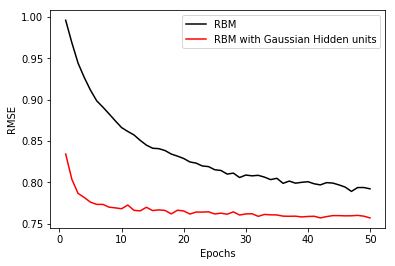

In [25]:
# Plot graphs for epochs vs loss for RBMs with binary as well as gaussian hidden units
epochs = [i for i in range(1, 51)]
plt.plot(epochs, rbm_loss, color='black', label='RBM')
plt.plot(epochs, rbm_gaussian, color='red', label='RBM with Gaussian Hidden units')
plt.ylabel('RMSE')
plt.xlabel('Epochs')

plt.grid(True, which='minor')
plt.legend()
plt.show()